# Gene Expression Analysis

## Environment

In [3]:
import warnings
warnings.filterwarnings('ignore')

import os
import sys
from pathlib import Path
from tqdm import tqdm

import yaml
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update({
    "pgf.texsystem": "xelatex",
    'font.family': 'serif',
    'text.usetex': False,
    'pgf.rcfonts': False,
    'figure.dpi': 300,
})

import scanpy as sc

In [4]:
# Loading the Packages
%reload_ext autoreload
%autoreload 2

lib_path = r'E:\TMC\PRISM_Code\analysis_cell_typing'
if lib_path not in sys.path:
    sys.path.append(lib_path)
    
# cell-typing
from cell_typing import QC_plot, general_preprocess, preprocess_of_UMAP, UMAP_genes_plot, UMAP_obs_plot, annotate
# spatial
from spatial import create_hull
# correlation analysis
from correlation import matrix_for_heatmap

In [5]:
BASE_DIR = Path('F:\spatial_data\processed')
RUN_ID = 'PRISM2D_mousebrain'
src_dir = BASE_DIR / f'{RUN_ID}'
stc_dir = src_dir / 'stitched'
read_dir = src_dir / 'readout'
seg_dir = src_dir / 'segmented'
cell_typ_dir = src_dir / "analysis_celltyping"
spatial_dir = src_dir / 'analysis_spatial'
sc_dir = Path('F:\spatial_data\dataset_sc_rnaseq')
os.makedirs(cell_typ_dir, exist_ok=True)

## load exp data

In [93]:
# expr_path = os.path.join(data_path, "expr_all.csv")
var_path = r"E:\TMC\.lib_legacy\cell_typing\dataset_spatial\PRISM_mousebrain\var.csv"
var = pd.read_csv(var_path, index_col=0)
var.index = pd.Series(var.index).replace({'3110035E14Rik': 'VXN'})
var_rename = {f'PRISM_{i+1}':list(var.index)[i] for i in range(30)}

# load expression matrix
exp_mtx = pd.read_csv(seg_dir / "expression_matrix.csv", index_col=0).drop('Other', axis=1)
exp_mtx.columns = exp_mtx.columns.map(var_rename)

with open(cell_typ_dir / 'params.yaml', 'r') as file: params = yaml.safe_load(file)
gene_list = params['gene_list']

In [94]:
adata = sc.AnnData(X=exp_mtx)
adata.var.index = adata.var.index.str.upper()
adata.obs['dataset'] = ["PRISM"] * len(adata)
adata.obs['tissue'] = ['mousebrain'] * len(adata)
adata = adata[:, gene_list]

# load spatial information
centroid = pd.read_csv(seg_dir / 'centroids_all.csv', header=None)
centroid.columns=[['y_in_pix', 'x_in_pix']]
centroid_sub = centroid.iloc[adata.obs.index]
adata.obsm['spatial'] = np.array([centroid_sub['y_in_pix'], centroid_sub['x_in_pix']]).T[0]

## Preprocess

maxima: [5.7, 86.45, 101.65, 111.14999999999999, 118.75, 123.5, 133.0, 139.65, 145.35, 152.0, 161.5, 166.25, 171.95000000000002, 173.85, 179.54999999999998, 185.25]


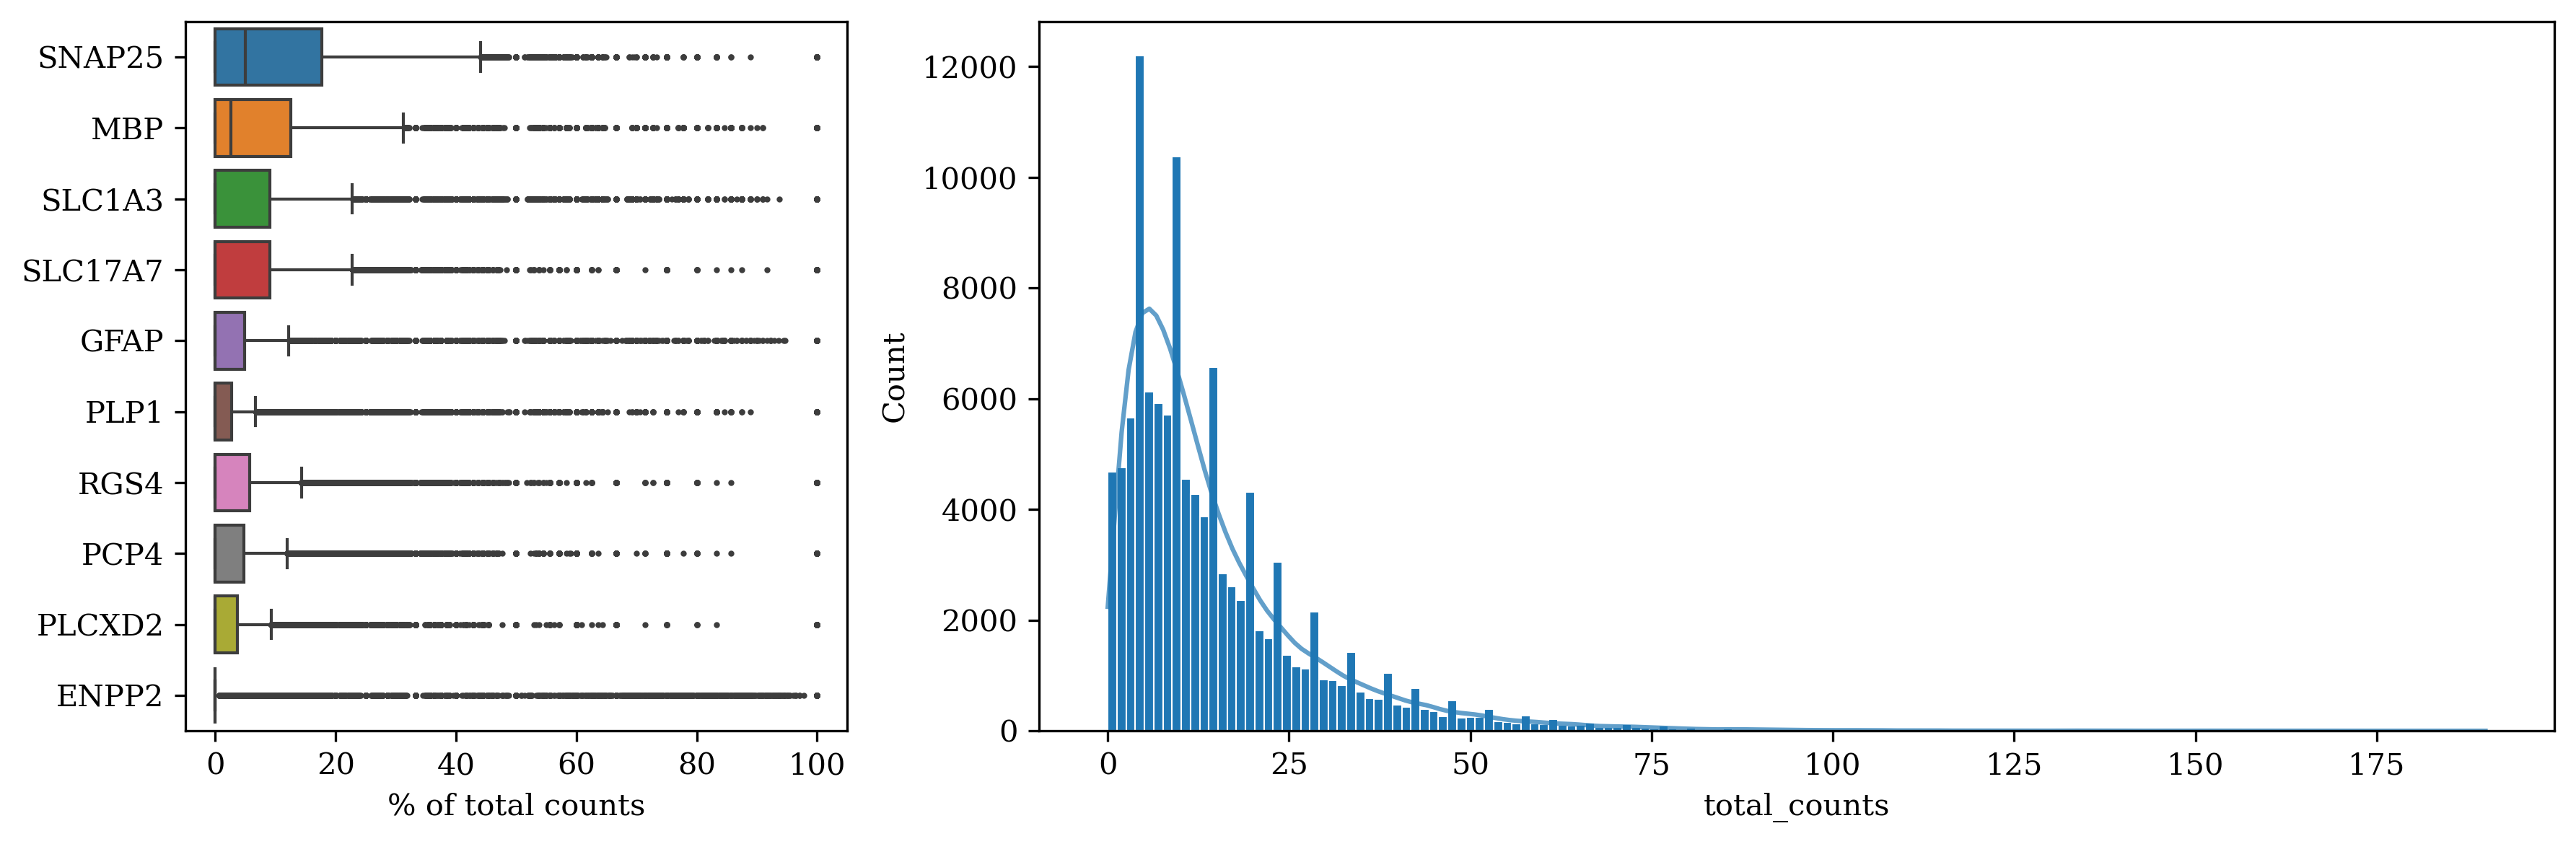

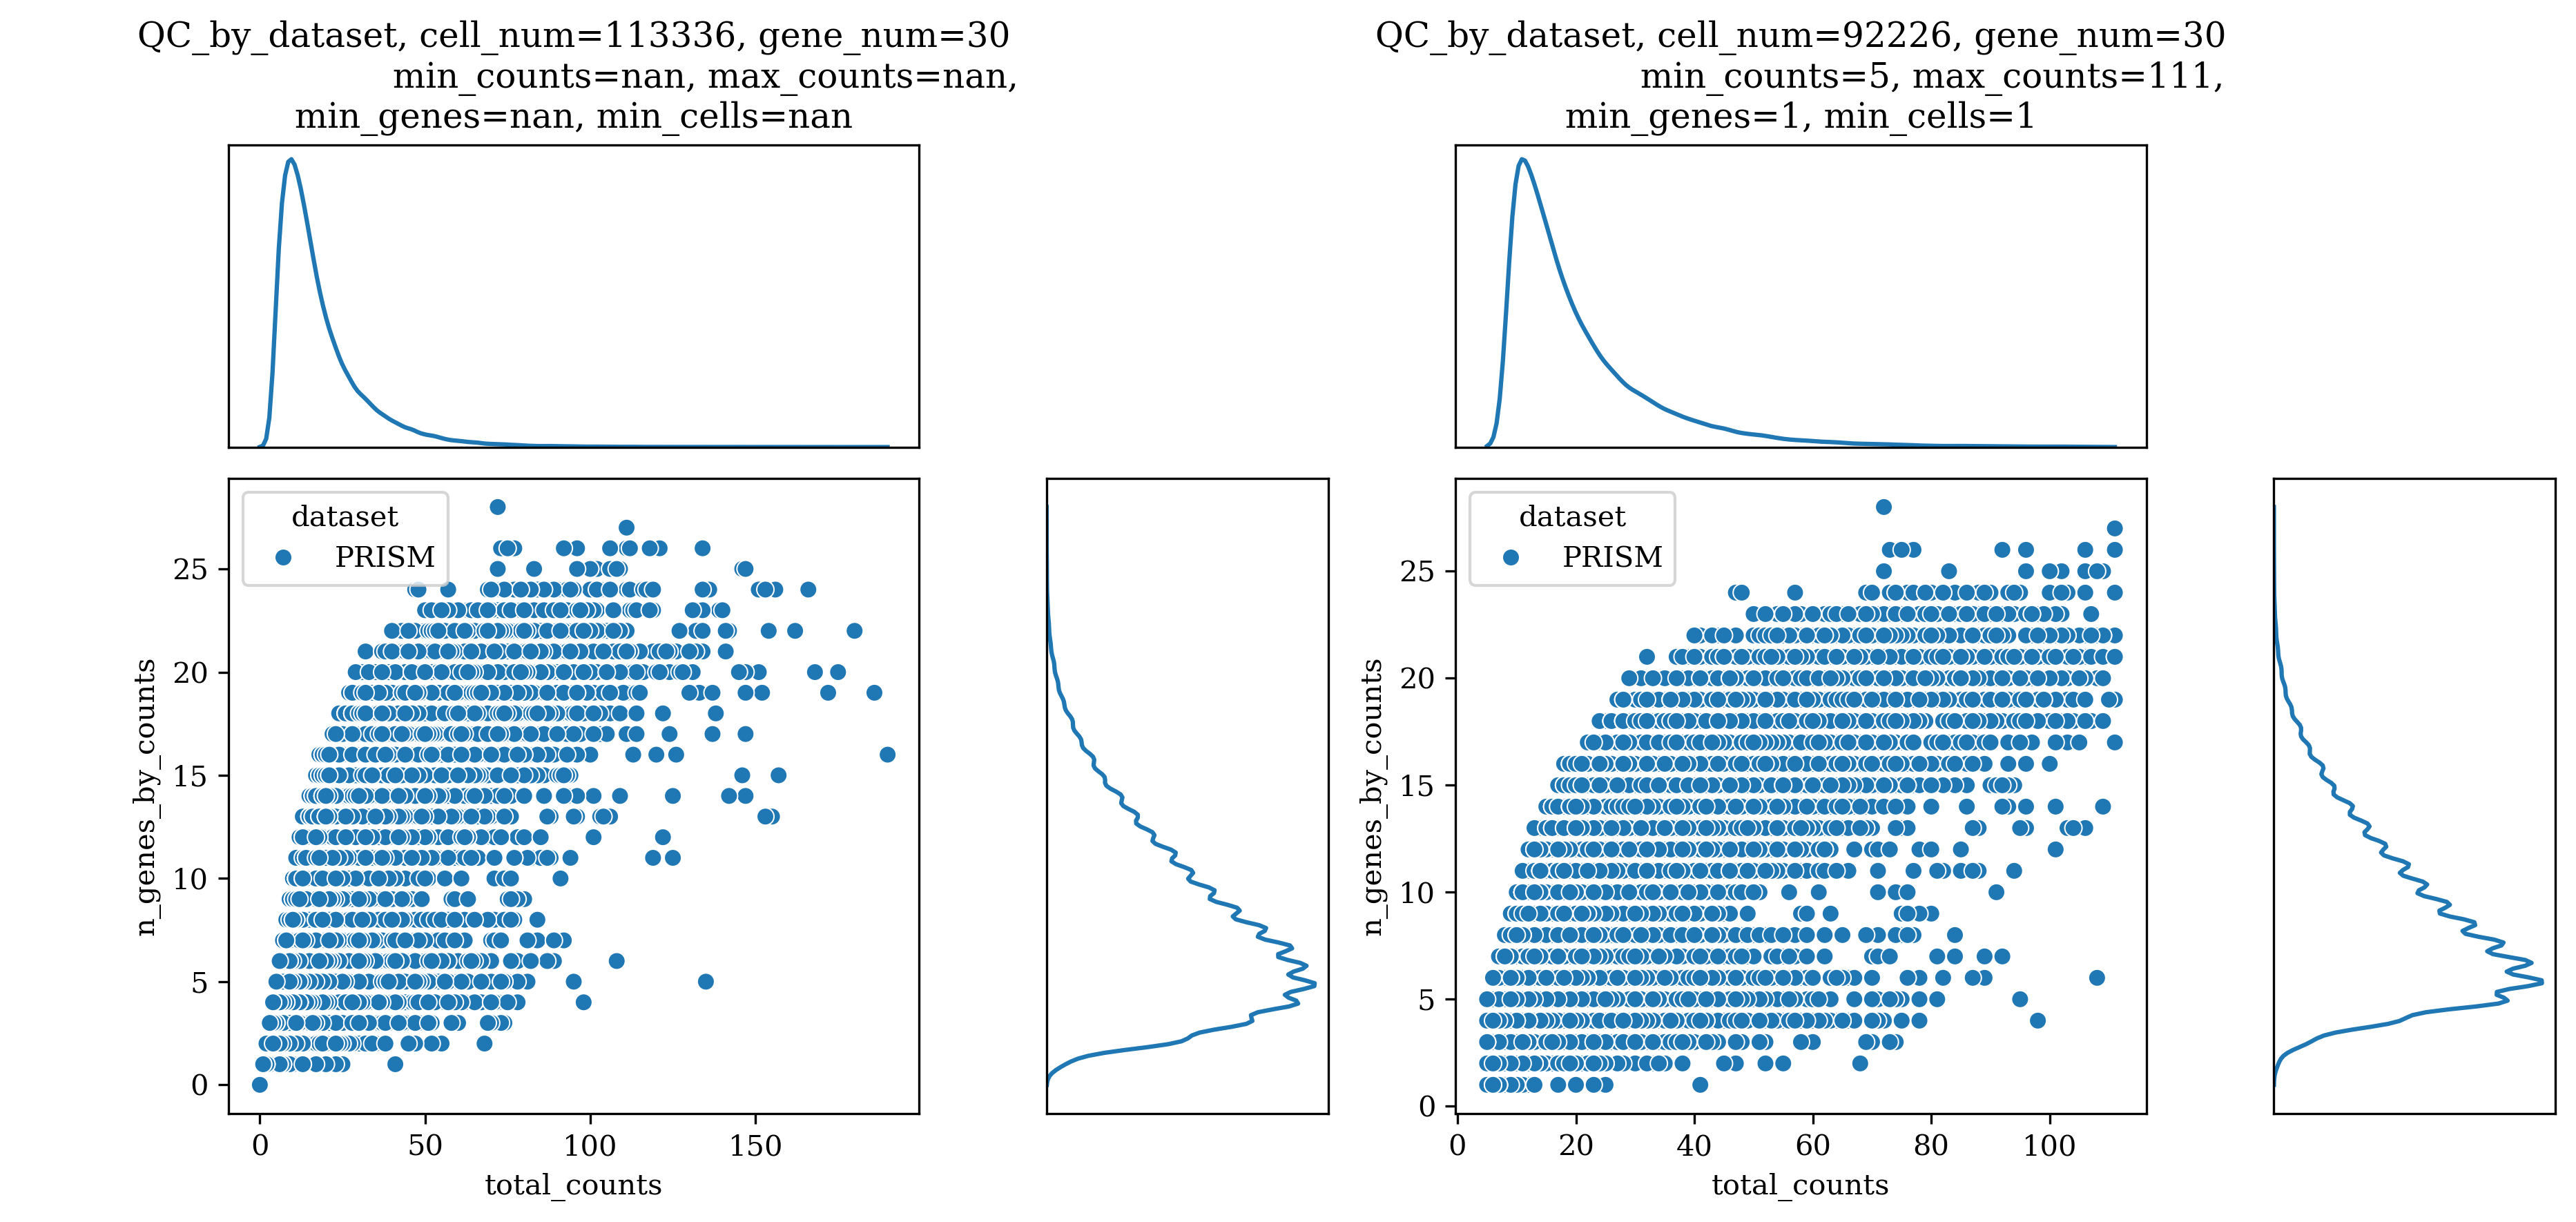

In [95]:
# process of gene name
adata, origin_cell_num, filtered_cell_num = general_preprocess(adata, min_genes=1, min_counts=6, max_counts=150, min_cells=1, auto_filter=True)
# copy the meta data of adata
adata.raw = adata.copy()

# direct leiden


## process

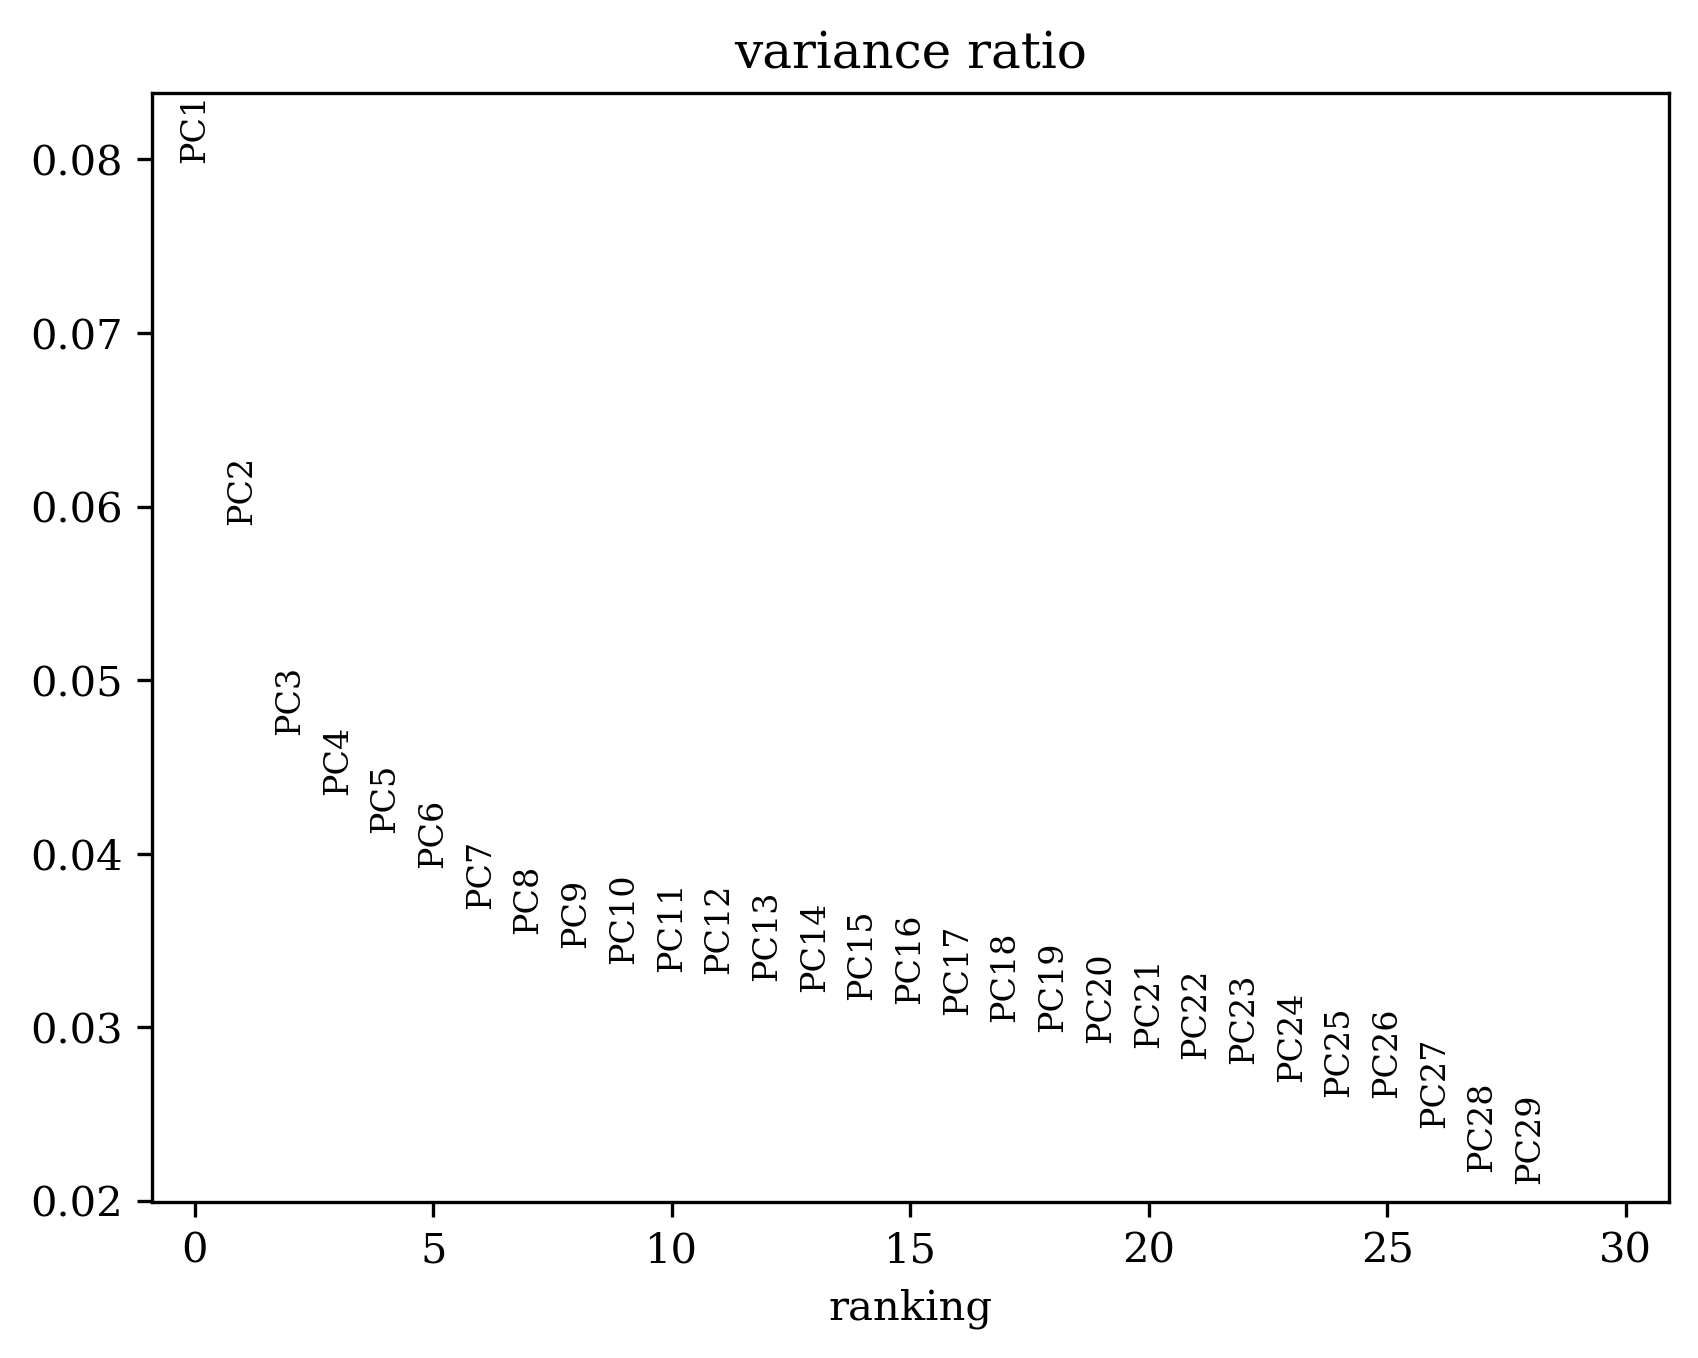

In [96]:
adata.X = adata.raw.X.copy()
# preprocess of UMAP
adata = preprocess_of_UMAP(adata)

# compute pca
sc.tl.pca(adata)
sc.pl.pca_variance_ratio(adata, log=False)

In [97]:
# select the num of pc
n_pcs=20
sc.tl.pca(adata, n_comps=n_pcs)

In [ ]:
# Run UMAP
sc.pp.neighbors(adata, n_neighbors=50, n_pcs=n_pcs)
sc.tl.umap(adata)

# Run Leiden cluster
sc.tl.leiden(adata, resolution=1)

## overview

### cell num of each leiden cluster

In [ ]:
a = [len(adata[adata.obs.leiden == _]) for _ in adata.obs.leiden.unique()]
fig, ax = plt.subplots(figsize=(7,3))
sns.histplot(a, bins=30, stat='count', alpha=1,
            edgecolor='white', linewidth=0.5,
            ax=ax, line_kws=dict(color='black', alpha=0.7, linewidth=1.5, label='KDE'),
            )
plt.savefig(cell_typ_dir / 'Leiden_cell_num_distribution.png', bbox_inches='tight', dpi=300)
plt.close()

### boxplot

In [ ]:
unknown_cluster = [str(_) for _ in sorted([int(_) for _ in adata.obs.leiden.unique()])]
fig, ax = plt.subplots(ncols=1, nrows=len(unknown_cluster),figsize =(25, 100))
for _, cluster_num  in enumerate(unknown_cluster):
    data = adata[adata.obs['leiden'] == cluster_num].X
    ax[_].boxplot(data, flierprops={'marker': 'o', 'markersize': 2, 'markerfacecolor': 'fuchsia'})
    ax[_].set_xticklabels(list(adata.var_names))
    ax[_].set_title(f'cluster{cluster_num}')
plt.savefig(cell_typ_dir / 'boxplot.png', bbox_inches='tight', dpi=300)
plt.close()

In [ ]:
# umap by gene
UMAP_genes_plot(adata, size=1, out_path=cell_typ_dir / 'direct_leiden')

# umap by leiden
UMAP_obs_plot(adata, color='leiden', datasets=['PRISM'], size=2, out_path=cell_typ_dir / 'direct_leiden')
QC_plot(adata, hue='leiden')

# harmony combine

## load sc data

In [ ]:
adata_sc = sc.read_h5ad(sc_dir / 'sc_data_mousebrain' / 'combine_sc_preprocesed.h5ad')

## process

In [99]:
combine_adata = adata.concatenate(adata_sc, batch_key="dataset", batch_categories=["PRISM", "10X"])

print("origin_gene_num:", len(adata.var.index))
print("combine_gene_num:", len(combine_adata.var.index))
print("Genes_not_matched:", ','.join(list(set(adata.var.index) - set(combine_adata.var.index))))

origin_gene_num: 30
combine_gene_num: 30
Genes_not_matched: 


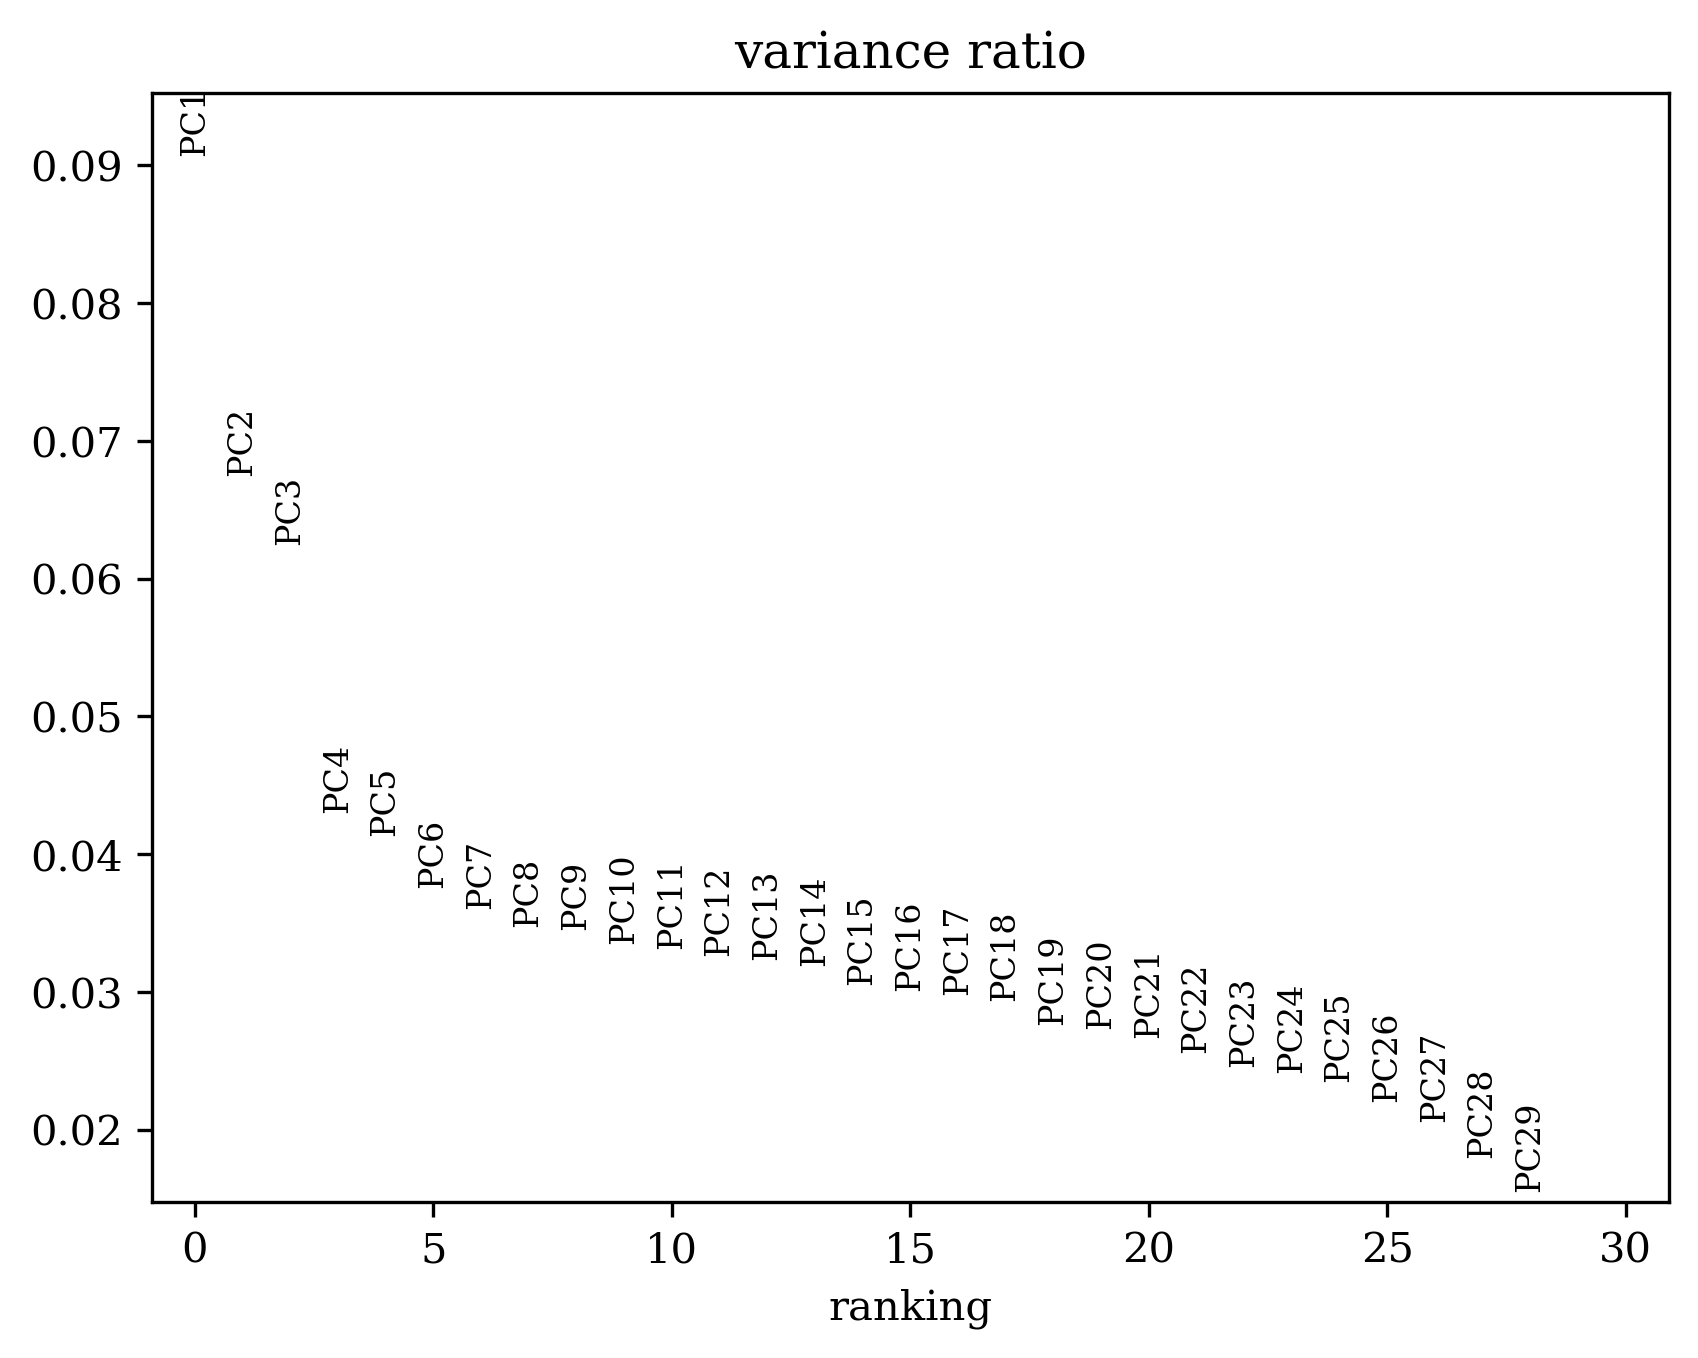

In [101]:
sc.tl.pca(combine_adata, n_comps=29)
sc.pl.pca_variance_ratio(combine_adata, log=False)

In [310]:
h_pcs = 29
sc.tl.pca(combine_adata, n_comps=h_pcs)
sc_cell_num = len(combine_adata) - len(adata)
print(combine_adata)

AnnData object with n_obs × n_vars = 207570 × 30
    obs: 'dataset', 'tissue', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_genes', 'n_counts', 'Age', 'AnalysisPool', 'AnalysisProject', 'CellConc', 'Cell_Conc', 'ChipID', 'Class', 'ClassProbability_Astrocyte', 'ClassProbability_Astrocyte,Immune', 'ClassProbability_Astrocyte,Neurons', 'ClassProbability_Astrocyte,Oligos', 'ClassProbability_Astrocyte,Vascular', 'ClassProbability_Bergmann-glia', 'ClassProbability_Blood', 'ClassProbability_Blood,Vascular', 'ClassProbability_Enteric-glia', 'ClassProbability_Enteric-glia,Cycling', 'ClassProbability_Ependymal', 'ClassProbability_Ex-Neurons', 'ClassProbability_Ex-Vascular', 'ClassProbability_Immune', 'ClassProbability_Immune,Neurons', 'ClassProbability_Immune,Oligos', 'ClassProbability_Neurons', 'ClassProbability_Neurons,Cycling', 'ClassProbability_Neurons,Oligos', 'ClassProbability_Neurons,Satellite-glia', 'ClassProbability_Neurons,Vascular', 'ClassPr

In [311]:
import scanpy.external as sce

sce.pp.harmony_integrate(
    combine_adata,
    "dataset",
    "X_pca",
    "X_pca_harmony",
    max_iter_harmony=30,
    # max_iter_kmeans=30,
)

2024-06-26 18:19:17,402 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-06-26 18:19:36,368 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-06-26 18:19:37,561 - harmonypy - INFO - Iteration 1 of 30
2024-06-26 18:21:16,848 - harmonypy - INFO - Iteration 2 of 30
2024-06-26 18:22:55,275 - harmonypy - INFO - Iteration 3 of 30
2024-06-26 18:24:24,170 - harmonypy - INFO - Iteration 4 of 30
2024-06-26 18:26:02,674 - harmonypy - INFO - Iteration 5 of 30
2024-06-26 18:26:39,134 - harmonypy - INFO - Iteration 6 of 30
2024-06-26 18:27:20,661 - harmonypy - INFO - Converged after 6 iterations


In [312]:
combine_adata.obs['ngperul_cDNA'] = combine_adata.obs['ngperul_cDNA'].astype(str)
combine_adata.obs['Num_Pooled_Animals'] = combine_adata.obs['Num_Pooled_Animals'].astype(str)

neighbor = 50
sc.pp.neighbors(combine_adata, n_neighbors=neighbor, use_rep="X_pca_harmony")
sc.tl.umap(combine_adata)

In [313]:
# umap by gene
UMAP_genes_plot(combine_adata, size=0.5, out_path=cell_typ_dir)

In [339]:
leiden_resolution=5
sc.tl.leiden(combine_adata, resolution=leiden_resolution)
combine_adata.obs.to_csv(cell_typ_dir / 'combine_adata_obs.csv')

In [12]:
# leiden_resolution=5
# combine_adata = sc.read_h5ad(cell_typ_dir / 'h_pcs=29' / 'combine_adata.h5ad')
# combine_adata.obs = pd.read_csv(cell_typ_dir / 'h_pcs=29' / 'leiden_res=5' / 'combine_adata_obs.csv', index_col=0)
# combine_adata.obs.leiden = combine_adata.obs.leiden.astype(str)
# combine_adata.obs.leiden = pd.Categorical(combine_adata.obs.leiden)

## visualization

### cell num of each leiden cluster

In [340]:
combine_adata_exp = combine_adata[combine_adata.obs.dataset == 'PRISM']
a = [len(combine_adata_exp[combine_adata_exp.obs.leiden == _]) for _ in combine_adata_exp.obs.leiden.unique()]
fig, ax = plt.subplots(figsize=(7,3))
sns.histplot(a, bins=30, stat='count', 
             alpha=1, edgecolor='white', linewidth=0.5, ax=ax,
             kde=True, line_kws=dict(color='black', alpha=0.7, linewidth=1.5, label='KDE'),
             )
ax.set_title('Cell Number Distribution of Leiden')
plt.savefig(cell_typ_dir / 'leiden_distribution.png', bbox_inches='tight', dpi=300)
plt.close()

### boxplot

In [341]:
unknown_cluster = [str(_) for _ in sorted([int(_) for _ in combine_adata.obs.leiden.unique()])]
fig, ax = plt.subplots(ncols=1, nrows=len(unknown_cluster),figsize =(25, 100))
for _, cluster_num  in enumerate(unknown_cluster):
    data = combine_adata[combine_adata.obs['leiden'] == cluster_num].X
    ax[_].boxplot(data, flierprops={'marker': 'o', 'markersize': 2, 'markerfacecolor': 'fuchsia'})
    ax[_].set_xticklabels(list(combine_adata.var_names))
    ax[_].set_title(f'cluster{cluster_num}')
    ax[_].set_ylim([-1, 5])
plt.savefig(cell_typ_dir / 'boxplot_cluster.png', dpi=300, bbox_inches='tight')
plt.close()

### umap

In [345]:
# umap by leiden
UMAP_obs_plot(combine_adata, color='leiden', datasets=['PRISM'], size=1.5, out_path=cell_typ_dir)

## annotate interested clusters

### spatial preview

In [10]:
combine_adata_st = combine_adata[combine_adata.obs.dataset == 'PRISM']
combine_adata_st.obs.index = [int(_.split('-')[0]) for _ in combine_adata_st.obs.index]
centroid = pd.read_csv(seg_dir / 'centroids_all.csv', header=None)
centroid.columns=[['y_in_pix', 'x_in_pix']]
centroid_sub = centroid.iloc[combine_adata_st.obs.index]
combine_adata_st.obsm['spatial'] = np.array([centroid_sub['x_in_pix'], centroid_sub['y_in_pix']]).T[0]

In [13]:
import matplotlib.gridspec as gridspec

for leiden in tqdm(range(len(combine_adata_st.obs.leiden.unique()))):
    group = [leiden]
    group = [str(_) for _ in group]
    group_name = ', '.join(group)
    tmp = combine_adata_st[combine_adata_st.obs.leiden.isin(group)]
    # if tmp.obs['leiden'].dtype == object: tmp.obs['leiden'] = tmp.obs['leiden'].astype('category').cat.codes 
    
    fig = plt.figure(figsize=(20, 16))
    gs = gridspec.GridSpec(10, 10)
    ax_box = fig.add_subplot(gs[:2, :])
    cell_num = len(tmp)
    ax_box.boxplot(tmp.X, flierprops={'marker': 'o', 'markersize': 2, 'markerfacecolor': 'fuchsia'})
    ax_box.set_ylim([-1, 5])
    ax_box.set_xticklabels(list(combine_adata_st.var_names))
    ax_box.set_title(f'cluster_{group_name}_{cell_num}')

    ax_2d = fig.add_subplot(gs[2:, :])
    ax_2d.invert_yaxis()
    sc.pl.embedding(tmp, basis="spatial", color="leiden", palette=['brown'] * len(group), 
                    size=50, alpha=1, ax=ax_2d, show=False)

    plt.tight_layout()
    plt.savefig(cell_typ_dir / f'res={leiden_resolution}, leiden_{group_name}.png', dpi=300, bbox_inches='tight')
    plt.close()

100%|██████████| 112/112 [02:36<00:00,  1.39s/it]


In [ ]:

# group = [26]
# group = [str(_) for _ in group]
# tmp = combine_adata_st[combine_adata_st.obs.leiden.isin(group)]

# fig = plt.figure(figsize=(20, 16))
# gs = gridspec.GridSpec(10, 10)

# ax_box = fig.add_subplot(gs[:2, :])
# data = combine_adata_st[combine_adata_st.obs['leiden'].isin(group)].X
# ax_box.boxplot(data, flierprops={'marker': 'o', 'markersize': 2, 'markerfacecolor': 'fuchsia'})
# ax_box.set_xticklabels(list(combine_adata_st.var_names))
# ax_box.set_title(f'cluster{group}')

# ax_2d = fig.add_subplot(gs[2:, :])
# ax_2d.invert_yaxis()
# sc.pl.embedding(
#     tmp, basis="spatial", color="leiden", palette=['brown'] * len(group),
#     size=50, alpha=1, ax=ax_2d, show=False)

# plt.tight_layout()
# plt.show()

### relabel mapping

In [7]:
import yaml


with open(cell_typ_dir / 'params.yaml', 'r') as file: params = yaml.safe_load(file)
cluster_dict = params['cluster_dict']
cluster_rough_dict = params['cluster_rough_dict']
for rough_type in cluster_rough_dict.keys():
    for fine_type in cluster_dict.keys():
        if rough_type in fine_type: cluster_rough_dict[rough_type] += cluster_dict[fine_type]

undefined_cluster = sorted([int(_) for _ in combine_adata_st.obs.leiden.unique()])
undefined_cluster = [_ for _ in undefined_cluster if _ not in [item for sublist in list(cluster_dict.values()) for item in sublist]]
print(undefined_cluster)

[7, 13, 19, 41, 48, 49, 68, 71, 75, 77, 79, 82, 83, 84, 85, 89, 90, 91, 92, 94, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 110, 111, 113]


### relabel of num and cluster name

In [15]:
# rename leidens based on cluster_dict
combine_adata_st = annotate(combine_adata_st, cluster_dict, in_leiden='leiden', out_leiden='leiden_subtype', out_type='subtype')
combine_adata_st = annotate(combine_adata_st, cluster_rough_dict, in_leiden='leiden', out_leiden='leiden_type', out_type='type')
combine_adata_st.obs = combine_adata_st.obs.dropna(axis=1)

In [ ]:
for cell_type in cluster_dict.keys():
    print(f'{cell_type}: {combine_adata_st[combine_adata_st.obs.subtype == cell_type].obs.subtype.count()}')

print('annotated:',len(combine_adata_st[combine_adata_st.obs.subtype.isin(cluster_dict.keys())]))
# print('total_exempt_other:',len(adata[adata.obs.type!='other']))
print('total:',len(combine_adata_st))

In [ ]:
combine_adata_st.write_h5ad(cell_typ_dir / 'combine_adata_st.h5ad')

# cell typing validation

In [6]:
with open(cell_typ_dir / 'params.yaml', 'r') as file: params = yaml.safe_load(file)
gene_list = params['gene_list']

combine_adata_st = sc.read_h5ad(cell_typ_dir / 'h_pcs=29' / 'combine_adata_st.h5ad')
combine_adata_st = combine_adata_st[:, gene_list]
adata_sc = sc.read_h5ad(sc_dir / 'sc_data_mousebrain' / 'CTX, HP, TH, HY combined' / 'combine_sc_preprocesed.h5ad')
adata_sc = adata_sc[:, gene_list]

In [70]:
subtype_list = list(cluster_dict.keys())
subtype_list.remove('Ex-CA2or3')
subtype_list.remove('Ex-other')
subtype_list.remove('In-other')

bulk_rna_sc = pd.DataFrame(index=subtype_list, columns=gene_list)
for subtype in subtype_list:
    bulk_rna_sc.loc[subtype] = adata_sc[adata_sc.obs.subtype == subtype].X.mean(axis=0)
bulk_rna_sc = bulk_rna_sc.astype(float)

bulk_rna_st = pd.DataFrame(index=subtype_list, columns=gene_list)
for subtype in subtype_list:
    bulk_rna_st.loc[subtype] = combine_adata_st[combine_adata_st.obs.subtype == subtype].X.mean(axis=0)
bulk_rna_st = bulk_rna_st.astype(float)

In [71]:
import numpy as np

# 假设df1和df2已经是numpy数组，每行是一个细胞类型的基因表达数据
data1 = bulk_rna_sc.values
data2 = bulk_rna_st.values
corr_matrix = np.corrcoef(np.vstack((data1, data2)))
corr_matrix = corr_matrix[:len(data1), len(data1):]

In [77]:
plt.rcParams['axes.facecolor'] = 'black'
plt.rcParams['axes.edgecolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'

fig, ax = plt.subplots(figsize=(20, 15),facecolor='black')
sns.heatmap(corr_matrix, cmap='inferno', ax=ax)
ax.set_title('Bulk RNA vs Single Cell')
ax.set_xlabel('PRISM')
ax.set_ylabel('Single Cell')
ax.set_xticklabels(subtype_list, rotation=45)
ax.set_yticklabels(subtype_list, rotation=0)
plt.savefig(cell_typ_dir / 'Bulk_RNA_vs_Single_Cell.pdf', bbox_inches='tight')
plt.close()

plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'black'

# Visualization: dotplot, umap, gene in types

## dotplot for type and subtype

In [58]:
# adata_tmp = sc.read_h5ad(cell_typ_dir / 'h_pcs=14' / 'combine_adata_st.h5ad')
# adata_raw_reordered = sc.read_h5ad(seg_dir/'adata_reordered.h5ad')

adata_tmp = combine_adata_st.copy()
adata_tmp.obs = combine_adata_st.obs.copy()
adata_tmp.raw = None  # remember that raw counts will be used to plot dotplots when it exists.

In [63]:
tmp_var_names = gene_list

tmp_category = [
    'Ex-L2or3', 'Ex-L4', 'Ex-L6a', 'Ex-L6b',
    'Ex-CA1', 'Ex-CA2or3', 'Ex-DG', 'Ex-TH', 'Ex-other', # 'Ex-PMCH',
    'In-SST', 'In-PVALB', 'In-VIP', 'In-other', 'In_Lamp5', 
    'Glial-Astrocyte', 'Glial-Microglia', 'Glial-Oligodendrocyte', 
    # 'Glial-Enpp2+'
    ]

tmp = adata_tmp[adata_tmp.obs.subtype != 'other']
tmp.obs.subtype = pd.Categorical(tmp.obs['subtype'], categories=tmp_category)

plt.rcParams['axes.facecolor'] = 'black'
plt.rcParams['axes.edgecolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'

fig, ax = plt.subplots(figsize=(12, 10), facecolor='black')
sc.pl.dotplot(tmp, var_names=tmp_var_names, groupby='subtype', vmax=5, ax=ax, show=False, cmap='viridis')
ax.set_facecolor('black')
ax.tick_params(axis='both', which='both', labelcolor='white')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')

fig.patch.set_facecolor('black')
plt.savefig(cell_typ_dir / 'dotplot_subtype.pdf', bbox_inches='tight')
plt.close()

plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'black'

## umap colored by genes, cluster and dataset

In [60]:
with open(cell_typ_dir / 'params.yaml', 'r') as file: params = yaml.safe_load(file)
subtype_colormap = params['subtype_colormap']
subtype_colormap = {k: [round(_/255, 1) for _ in v] for k, v in subtype_colormap.items()}

In [61]:
from cell_typing import UMAP_obs_plot

tmp = combine_adata_st[~combine_adata_st.obs['subtype'].isin(['other','Ex-other','In-other'])]
UMAP_obs_plot(adata=tmp, color='subtype',
    palette=subtype_colormap, size=3, legend_loc="right margin", face_color='black',out_path=cell_typ_dir, )

# UMAP_genes_plot(adata=tmp,
# FOI=FOI, save=False, out_path=r'./', datatype='harmony', dataset=['PRISM_HCC'])

## plot gene distribution of each cluster

In [62]:
subtype_list = list(cluster_dict.keys())
fig, ax = plt.subplots(ncols=1, nrows=len(subtype_list),figsize =(25, 100))
for _, subtype  in enumerate(subtype_list):
    data = combine_adata_st[combine_adata_st.obs['subtype'] == subtype].X
    ax[_].boxplot(data, flierprops={'marker': 'o', 'markersize': 2, 'markerfacecolor': 'fuchsia'})
    ax[_].set_xticklabels(list(combine_adata_st.var_names))
    ax[_].set_title(f'{subtype}')
    ax[_].set_ylim([-1, 5])
plt.savefig(cell_typ_dir / 'boxplot_subtype.png', dpi=300, bbox_inches='tight')
plt.close()

# Spatial projection

In [64]:
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch

subtype_of_interest = cluster_dict.keys()
tmp = combine_adata_st[combine_adata_st.obs.subtype.isin(subtype_of_interest)]

fig = plt.figure(figsize=(14, 10))
gs = gridspec.GridSpec(1, 10)
ax_2d = fig.add_subplot(gs[0, :9])
ax_2d.invert_yaxis()
sc.pl.embedding(tmp, basis="spatial", color="subtype", palette=subtype_colormap,size=8, alpha=0.8, ax=ax_2d, show=False)
ax_2d.set_facecolor('black')
ax_2d.invert_xaxis()

legend = ax_2d.get_legend()
legend.remove()
by_label = {label: idx for idx, label in enumerate(tmp.obs["subtype"].cat.categories)}
legend_handles = [Patch(color=subtype_colormap[label], label=label) for label in by_label]
legend = ax_2d.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

plt.tight_layout()
plt.show()

In [65]:
# plot type cluster
# tmp_adata = combine_adata_st[combine_adata_st.obs.type != 'other']
tmp_adata = combine_adata_st.copy()
tmp_adata.obs.index = [_.split('-')[0] for _ in tmp_adata.obs.index]
hulls, type_indices = create_hull(tmp_adata, clus_obs="subtype", cont_thre=5,
                        rna_pos = pd.read_csv(read_dir / 'rna_labeled_Brain.csv'))

hull: 100%|██████████| 113336/113336 [02:24<00:00, 786.80it/s] 


In [66]:
with yaml.safe_load(open(cell_typ_dir / 'params.yaml', 'r')) as f: params = f
projection_order = params['projection_order']

In [67]:
from spatial import show_cluster


tmp_adata.obs["subtype"] = tmp_adata.obs["subtype"].astype('category')
fig, ax = plt.subplots(figsize=(16, 12))
show_cluster(hulls, type_indices, 
              cluster_list = projection_order, cluster_colormap = subtype_colormap, 
              ax=ax, linewidth=0.5, xlim=[-1000, 65000], ylim=[-1000, 50000],
              leave=True, show=False , save=False)

ax.set_facecolor('black')
ax.invert_xaxis()
ax.invert_yaxis()
by_label = {label: idx for idx, label in enumerate(tmp_adata.obs["subtype"].cat.categories)}
legend_handles = [Patch(color=subtype_colormap[label], label=label) for label in by_label]
legend = ax.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

fig.suptitle(f'2D_Projection, cell_num={len(tmp_adata)}\n\n', fontsize=20)
plt.savefig(cell_typ_dir / 'type_projection.png', dpi=300, bbox_inches='tight')
plt.close()

cell for cluster_Ex-CA2or3: 100%|██████████| 197/197 [00:00<00:00, 1698.30it/s]


# Quantitative spatial analysis

In [ ]:
import squidpy as sq


combine_adata_st = sc.read_h5ad(cell_typ_dir / 'h_pcs=29' / 'combine_adata_st.h5ad')
with yaml.safe_load(open(cell_typ_dir / 'params.yaml', 'r')) as f: params = f
neighbor_cluster = params['neighbor_cluster']

In [ ]:
tmp = combine_adata_st.copy()
tmp.obs.subtype = pd.Categorical(tmp.obs.subtype, categories=neighbor_cluster)
sq.gr.nhood_enrichment(tmp, cluster_key="subtype")

fig, ax = plt.subplots(figsize=(10, 10))
sq.pl.nhood_enrichment(tmp, cluster_key="subtype", cmap="coolwarm",
                       vmin=-100, vmax=100, ax=ax)
plt.savefig(cell_typ_dir / 'nhood_enrichment.png', dpi=300, bbox_inches='tight')
plt.close()

In [ ]:
## Plot: spatial auto correlation
sq.gr.co_occurrence(tmp, cluster_key="subtype")

## Plot interaction matrix
sq.gr.interaction_matrix(tmp, cluster_key="subtype")